In [5]:
import numpy as np
import pandas as pd

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
df=pd.read_csv('u.data') # Movie Lens Data Set.
df.head()

,0\t50\t5\t881250949
0,0\t172\t5\t881250949
1,0\t133\t1\t881250949
2,196\t242\t3\t881250949
3,186\t302\t3\t891717742
4,22\t377\t1\t878887116


In [8]:
df=pd.read_csv('u.data',sep="\t")   
df.head()

,0,50,5,881250949
0,0,172,5,881250949
1,0,133,1,881250949
2,196,242,3,881250949
3,186,302,3,891717742
4,22,377,1,878887116


In [9]:
df=pd.read_csv('u.data',sep="\t",names=['user_id', 'item_id', 'rating', 'timestamp']) 
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [10]:
title=pd.read_csv('Movie_Id_Titles') #Movie Lens Data Title Set.
title.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [11]:
df = pd.merge(df,title,on='item_id') # merging both DataFrames based on item_id
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [12]:
df.info() #quick overlook of our data.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100003 entries, 0 to 100002
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    100003 non-null  int64 
 1   item_id    100003 non-null  int64 
 2   rating     100003 non-null  int64 
 3   timestamp  100003 non-null  int64 
 4   title      100003 non-null  object
dtypes: int64(4), object(1)
memory usage: 4.6+ MB


In [13]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()             #most rated films

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [14]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())          # average rating grouped by title.
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


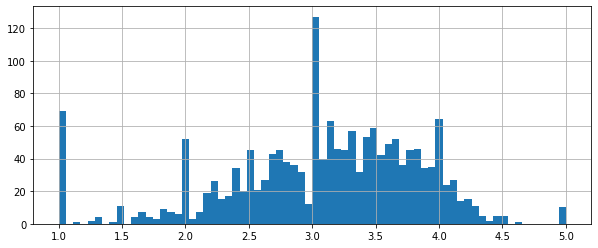

In [15]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

In [16]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())       #number of rating per movie title

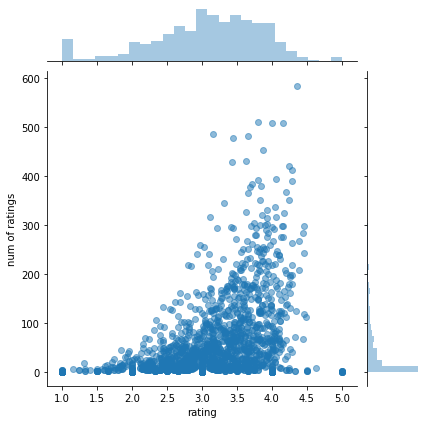

In [17]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)

In [18]:
n_users = df.user_id.nunique()                         # number of unique users and movies.
n_items = df.item_id.nunique()

print('Num. of Users: '+ str(n_users))
print('Num of Movies: '+str(n_items))

Num. of Users: 944
Num of Movies: 1682


In [19]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.3)

In general, Collaborative filtering (CF) is more commonly used than content-based systems because it usually gives better results and is relatively easy to understand (from an overall implementation perspective). The algorithm has the ability to do feature learning on its own, which means that it can start to learn for itself what features to use.

CF can be divided into Memory-Based Collaborative Filtering and Model-Based Collaborative filtering.

I will implement Model-Based CF by using singular value decomposition (SVD) and Memory-Based CF by computing cosine similarity.

Memory-Based Collaborative Filtering approaches can be divided into two main sections: user-item filtering and item-item filtering.

A user-item filtering will take a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked.

In contrast, item-item filtering will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations.

I will be using  User-Item filtering.

A distance metric commonly used in recommender systems is cosine similarity, where the ratings are seen as vectors in n-dimensional space and the similarity is calculated based on the angle between these vectors. Cosine similiarity for users a and m can be calculated using the formula below, where you take dot product of the user vector  𝑢𝑘  and the user vector  𝑢𝑎  and divide it by multiplication of the Euclidean lengths of the vectors.

https://latex.codecogs.com/gif.latex?s_u^{cos}(u_k,u_a)=\frac{u_k&space;\cdot&space;u_a&space;}{&space;\left&space;\|&space;u_k&space;\right&space;\|&space;\left&space;\|&space;u_a&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{k,m}x_{a,m}}{\sqrt{\sum&space;x_{k,m}^2\sum&space;x_{a,m}^2}}

In [20]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

In [21]:
#  use the pairwise_distances function from sklearn to calculate the cosine similarity. Note, the output will range from 0 to 1 since the ratings are all positive.

from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

Next step is to make predictions. I have already created similarity matrices: user_similarity and item_similarity and therefore you can make a prediction by applying following formula for user-based CF:
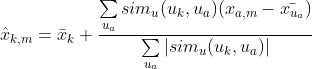


In [22]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #I use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [23]:
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

There are many evaluation metrics but one of the most popular metric used to evaluate accuracy of predicted ratings is Root Mean Squared Error (RMSE).

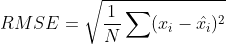

In [24]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [25]:
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 3.159993553006959
Item-based CF RMSE: 3.466195242045218
